In [1]:
import pickle

import jax.numpy as jnp
import jax
from jax import vmap

from ott.geometry import segment, pointcloud, geometry
from ott.problems.quadratic import gw_barycenter as gw_prob
from ott.solvers.quadratic import gw_barycenter as gw_solver
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein, lower_bound, gromov_wasserstein_lr
import time
import numpy as np

In [12]:
def dist_function(xx, yy, wxx, wyy, solver, LB=True):
    """
    Compute the Gromov-Wasserstein distances between one set of point clouds and another.
    """

    geom_xx = pointcloud.PointCloud(xx)
    geom_yy = pointcloud.PointCloud(yy)
    out = solver(quadratic_problem.QuadraticProblem(geom_xx, geom_yy, a=wxx, b=wyy, scale_cost=False))
    if LB:
        return out.reg_ot_cost, out.converged
    else:
        return out.reg_gw_cost, out.converged

vectorized_dist_function_single_loop = jax.jit(vmap(dist_function, (0, 0, 0, 0, None), 0))
vectorized_dist_function_double_loop = jax.jit(vmap(vmap(dist_function,
                                     (None, 0, None, 0, None), 0),
                                (0, None, 0, None, None), 0))

def sample_pointclouds(xtrain, ytrain, xval, yval, num_classes, num_pointclouds):
    xtrain_s = []
    ytrain_s = []
    xtest_s = []
    ytest_s = []
    for i in range(num_classes):
        indices = [s for s in range(len(ytrain)) if ytrain[s]==i]
        #indices = slice(*idxs[0:num_pointclouds])
        for s in range(num_pointclouds):
            xtrain_s.append(xtrain[indices[s]])
            ytrain_s.append(ytrain[indices[s]])
            xtest_s.append(xval[indices[s]])
            ytest_s.append(yval[indices[s]])
    return xtrain_s, ytrain_s, xtest_s, ytest_s


def sample_pointclouds(xtrain, ytrain, xval, yval, classes, num_pointclouds, num_pointclouds_test):
    xtrain_s = []
    ytrain_s = []
    xtest_s = []
    ytest_s = []
    idxs_out =[]
    idxs_out_test = []
    for i in classes:
        indices = [s for s in range(len(ytrain)) if ytrain[s]==i]
        indices_test = [s for s in range(len(yval)) if yval[s]==i]
        #indices = slice(*idxs[0:num_pointclouds])
        if num_pointclouds == -1 or num_pointclouds>len(indices):
            num_pointclouds = len(indices)
        if num_pointclouds_test == -1 or num_pointclouds_test>len(indices_test):
            num_pointclouds_test = len(indices_test)
        for s in range(num_pointclouds):
            xtrain_s.append(xtrain[indices[s]])
            ytrain_s.append(ytrain[indices[s]])
            idxs_out = indices[s]
        for s in range(num_pointclouds_test):
            xtest_s.append(xval[indices_test[s]])
            ytest_s.append(yval[indices_test[s]])
            idxs_out_test = indices_test[s]
    return xtrain_s, ytrain_s, xtest_s, ytest_s, idxs_out, idxs_out_test

def experiments(num_points, epsilon, classes, num_pointclouds, rank, LB=False):
    data = pickle.load(open(f"ModelNet_np_withLabels_pts={num_points}.pkl", "rb"))
    print(data['train_pos'][0].shape)
    xtrain_s, ytrain_s, xtest_s, ytest_s, indices, indices_test = sample_pointclouds(data['train_pos'], data['train_y'], data['val_pos'], data['val_y'],
                                                                                     classes, num_pointclouds, num_pointclouds)
    total_points, total_weights = segment.segment_point_cloud(jnp.concatenate(xtrain_s + xtest_s), num_per_segment=[cloud.shape[0] for cloud in xtrain_s + xtest_s])
    print(len(xtrain_s), len(xtest_s), len(xtrain_s+xtest_s))

    if LB: #use lowerbound
      d_solver = lower_bound.LowerBoundSolver(epsilon)
    else:
      d_solver = gromov_wasserstein.GromovWasserstein(epsilon=epsilon, rank=rank)

    n_total = len(total_points)
    idxs = jnp.array([[i,j] for i in range(n_total) for j in range (i, n_total)])
    t = time.time()
    kernel_features, converged = vectorized_dist_function_single_loop(total_points[idxs[:,0],:,:], total_points[idxs[:,1],:,:], total_weights[idxs[:,0],:], total_weights[idxs[:,1],:], d_solver)
    print(converged.all())
    elapsed = time.time() - t
    print("elapsed time", elapsed)

    #unpack distances into a matrix
    D = np.zeros((n_total,n_total))
    for aux in zip(idxs, kernel_features):
        D[aux[0][0], aux[0][1]] = aux[1]
    kernel_matrix = jnp.array(D + D.transpose())
    print(kernel_matrix)
    pickle.dump((kernel_matrix, xtrain_s, ytrain_s, xtest_s, ytest_s, indices, indices_test, converged, elapsed), open("GW_points{0}_epsilon{1}_classes{2}_clouds_{3}_rank{4}_LB={5}.pkl".format(num_points, epsilon, classes, num_pointclouds, rank, LB), "wb"))
    return kernel_matrix

In [3]:
x = jax.device_put(1, jax.devices('gpu')[2])
print(x.device_buffer.device())

gpu:2


In [ ]:
data = pickle.load(open(f"ModelNet_np_withLabels_pts=100.pkl", "rb"))
classes = [2,7]
num_pointclouds=40
epsilon = 0.01
print(data['train_pos'][0].shape)
xtrain_s, ytrain_s, xtest_s, ytest_s, indices, indices_test = sample_pointclouds(data['train_pos'], data['train_y'], data['val_pos'], data['val_y'],
                                                                                     classes, num_pointclouds, num_pointclouds)
total_points, total_weights = segment.segment_point_cloud(jnp.concatenate(xtrain_s + xtest_s), num_per_segment=[cloud.shape[0] for cloud in xtrain_s + xtest_s])
print(len(xtrain_s), len(xtest_s), len(xtrain_s+xtest_s))
total_points = jax.device_put(total_points, jax.devices('gpu')[2])
total_weights = jax.device_put(total_weights, jax.devices('gpu')[2])


In [34]:
d_solver = lower_bound.LowerBoundSolver(epsilon)
n_total = len(total_points)
#idxs = jnp.array([[i,j] for i in range(n_total) for j in range (i, n_total)])
idxs_train =  jnp.array([[i,j] for i in range(num_pointclouds) for j in range (num_pointclouds, num_pointclouds*2)])
idxs_test =  jnp.array([[i,j] for i in range(num_pointclouds*2, num_pointclouds*3) 
                                    for j in range (num_pointclouds*3, num_pointclouds*4)])

In [35]:
len(idxs_train), len(idxs_test)

(1600, 1600)

In [36]:
t = time.time()
kernel_train, converged = vectorized_dist_function_single_loop(total_points[idxs_train[:,0],:,:], total_points[idxs_train[:,1],:,:], 
                               total_weights[idxs_train[:,0],:], total_weights[idxs_train[:,1],:], d_solver)
print(converged.all())
elapsed = time.time() - t
print("elapsed time", elapsed)

2024-01-16 07:02:35.614998: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


True
elapsed time 12.515918254852295


In [41]:
pickle.dump(kernel_train, open("LB_GW_train.pkl", "wb"))

In [42]:
t = time.time()
kernel_test, converged_test = vectorized_dist_function_single_loop(total_points[idxs_test[:,0],:,:], total_points[idxs_test[:,1],:,:], 
                               total_weights[idxs_test[:,0],:], total_weights[idxs_test[:,1],:], d_solver)
print(converged_test.all())
elapsed = time.time() - t
print("elapsed time", elapsed)

True
elapsed time 9.477553844451904


In [43]:
pickle.dump(kernel_test, open("LB_GW_test.pkl", "wb"))

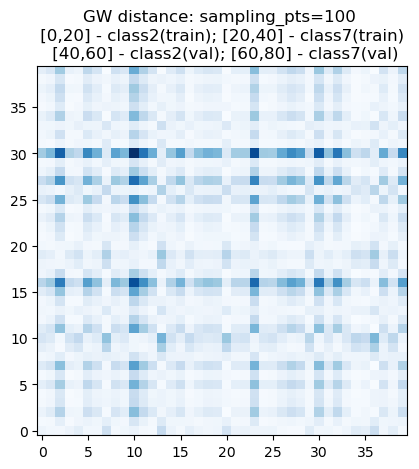

In [38]:
import matplotlib.pyplot as plt
#np.fill_diagonal(D, 0)
plt.imshow(kernel_train.reshape(40,40), cmap='Blues', origin='lower') #doesn't look too convincing there is clear separation between two classes...but let's see if the regressor cares?
plt.title(f"GW distance: sampling_pts={100} \n [0,20] - class2(train); [20,40] - class7(train) \n [40,60] - class2(val); [60,80] - class7(val)")
plt.show()